In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm

import random

### Mixed-membership

We want to sample nodes that come from a mixed membership model, i.e. less good clustering. Then want to test how good our bootstraps of nodes look, and apply our KL test to test this formally.

In [31]:
# Code up a mixed membership model 
random.seed(222)

K=3
n= 300
d=3

# use our new function to make a MMSBM 
# 1May24 I added return B to the function, so I can add to the paper what B is for our example
A, largest_prob, P, B = make_MMSBM(n, K)

A = A.astype(float)
ya = UASE([A], d)
plot_embedding(ya, n, 1, largest_prob)

In [3]:
title="MMSBM with n=300 nodes embedded with UASE into d=3 dimensions"
T=1

yadf = pd.DataFrame(ya[:, 0:2])
yadf.columns = ["Dimension {}".format(i + 1) for i in range(yadf.shape[1])]
yadf["Time"] = np.repeat([t for t in range(T)], n)
yadf["Community"] = list(largest_prob) 
yadf["Community"] = yadf["Community"].astype(str)
pad_x = (max(ya[:, 0]) - min(ya[:, 0])) / 50
pad_y = (max(ya[:, 1]) - min(ya[:, 1])) / 50
fig = px.scatter(
    yadf,
    x="Dimension 1",
    y="Dimension 2",
    color="Community",
    animation_frame="Time",
    range_x=[min(ya[:, 0]) - pad_x, max(ya[:, 0]) + pad_x],
    range_y=[min(ya[:, 1]) - pad_y, max(ya[:, 1]) + pad_y])

# fig.update_layout(title=title, title_font_size=14)
fig.update_traces(marker=dict(size=5))  # Adjust the size as desired
fig.update_layout(
    width=600,  # Adjust width as desired
    height=300,  # Adjust height as desired
)

fig.write_image("MMSBM_n300_UASE_d3.png")

fig.show()

[6619:0508/114655.059472:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [32]:
random.seed(222)

# Generate B matrix - this has 0.2 for all off-diagonal entries
B = np.ones((K, K)) * 0.2
comm_probs = np.linspace(0.3, 0.9, K)
np.fill_diagonal(B, comm_probs)

# make all the pi vectors (n of them)
pi_list = []
largest_prob = []
for i in range(n):
    # pi is a random probability vector of length K
    pi = np.random.dirichlet(np.ones(K)).reshape((K, 1))
    pi_list.append(pi)
    largest_prob.append(np.argmax(pi))

# (pi_list[0].T @ B @ pi_list[1])[0][0]

P = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
        z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

        P[i,j] = z_ij @ B @ z_ji.T

A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)

A = A.astype(float)

In [5]:
pi

array([[0.47377539],
       [0.52348203],
       [0.00274258]])

In [6]:
B

array([[0.3, 0.2, 0.2],
       [0.2, 0.6, 0.2],
       [0.2, 0.2, 0.9]])

This isn't actually community, it is just the one probabilistically they are most likely to belong to

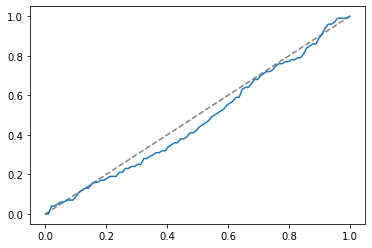

0.06

In [33]:
random.seed(12)

A_obs = A.copy()
p_vals, A_ests = test_bootstrap(A_obs, K, B=100,n_neighbors=10)
A_est = A_ests[0]

plot_power(p_vals, plot=True)

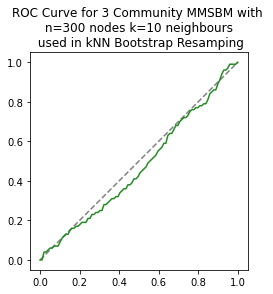

In [38]:
random.seed(12)

p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 3 Community MMSBM with \n n=300 nodes k=10 neighbours \n used in kNN Bootstrap Resamping")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("MMSBM_n300_UASE_d3_curve.png")

plt.show()

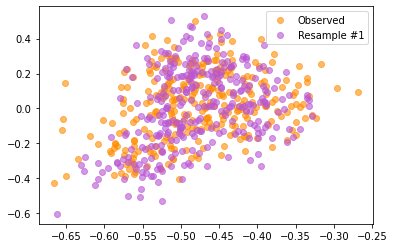

In [35]:

yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=0.6, color='#FF8C00')
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Resample #1", alpha=0.6, color='#BA55D3')
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.savefig("MMSBM_n300_UASE_d3_obs_B1.png")

plt.legend()

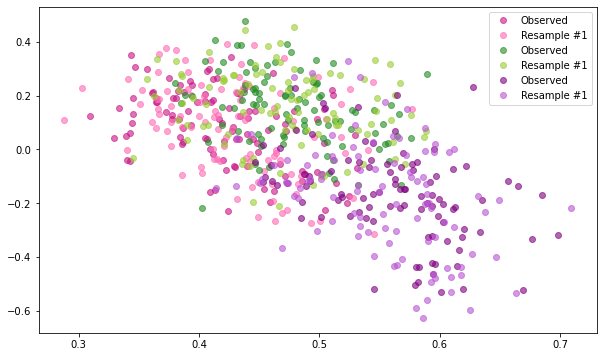

In [17]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

from matplotlib.colors import ListedColormap
cmap = plt.cm.get_cmap('Set2', K)   

# Define custom colors for the colormap
custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']  # Example colors, you can adjust these
custom_colors2 = ['#FF69B4', '#9ACD32', '#BA55D3', '#FFC300']  

# Create a custom colormap using ListedColormap
custom_cmap = ListedColormap(custom_colors)
custom_cmap2 = ListedColormap(custom_colors2)

plt.figure(figsize=(10, 6))

for i, label in enumerate(set(largest_prob)):
    indices = [idx for idx, value in enumerate(largest_prob) if value == label]
    plt.plot(yhat_est[0, indices, 0], yhat_est[0, indices, 1], 'o', label="Observed", alpha=0.6, color=custom_cmap.colors[i])
    plt.plot(yhat_est[1, indices, 0], yhat_est[1, indices, 1], 'o', label="Resample #1", alpha=0.6, color=custom_cmap2.colors[i])

plt.legend()

### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

#### SHOULD WE BE RESAMPLING THE PI VECTORS OR IS IT CORERCT TO KEEP THEM FIXED?

In [14]:
# Generate more samples from the same model with the same B matrix and pi vectors
random.seed(100)

M=300
A_true_draws = []

for m in range(M):
    # use the B matrix from before, B, and the pi vectors, pi_list
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
            z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

            P[i,j] = z_ij @ B @ z_ji.T

    A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)

    A = A.astype(float)

    A_true_draws.append(A)

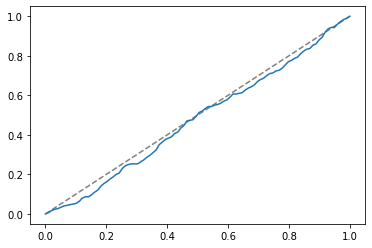

0.03333333333333333

In [15]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
p_vals = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=2000, n_neighbors=10)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Plot the ROC curve
plot_power(p_vals, plot=True)

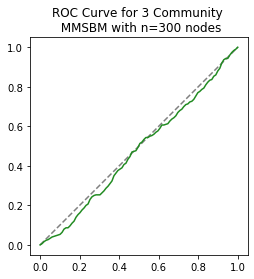

In [16]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 3 Community \n MMSBM with n=300 nodes")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("MMSBM_n300_M300_Q2000_UASE_d3_curve.png")

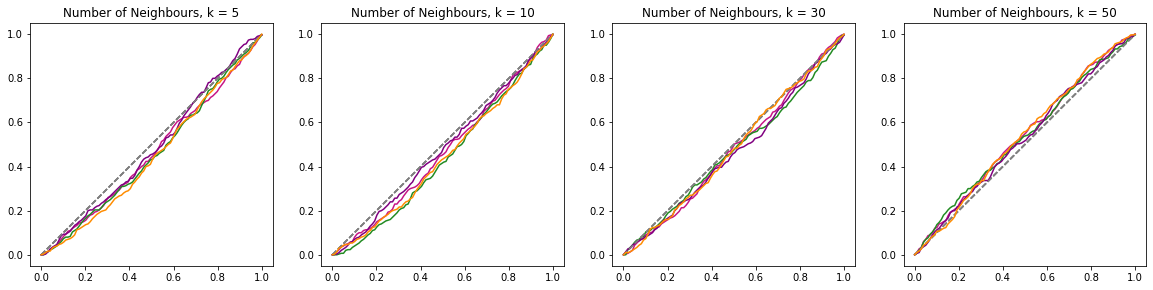

In [18]:
random.seed(100)

# Define the values of n_neighbors
neighbors_values = [5, 10, 30, 50]

custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']

# Create subplots
fig, axes = plt.subplots(1, len(neighbors_values), figsize=(20, 5))

# Loop through different values of n_neighbors
for i, n_neighbors in enumerate(neighbors_values):
    for iter in range(4):
        p_vals = []
        A_boots_list = []
        for m in A_true_draws:
            p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=n_neighbors)
            p_vals.append(p_val)
            A_boots_list.append(A_boots)

        roc = []
        alphas = []
        for alpha in np.linspace(0, 1, 100):
            alphas.append(alpha)
            num_below_alpha = sum(p_vals < alpha)
            roc_point = num_below_alpha / len(p_vals)
            roc.append(roc_point)

        # Get the power at the 5% significance level
        power_significance = 0.05
        power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
        power = roc[power_idx]

        axes[i].plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
        _ = axes[i].plot(alphas, roc, color=custom_colors[iter])

        # Set title and aspect ratio
        axes[i].set_title("Number of Neighbours, k = {}".format(n_neighbors))
        axes[i].set_aspect('equal', adjustable='box')

fig.savefig("MMSBM_n300_Q1000_M300_kchoices_4iterations.png")

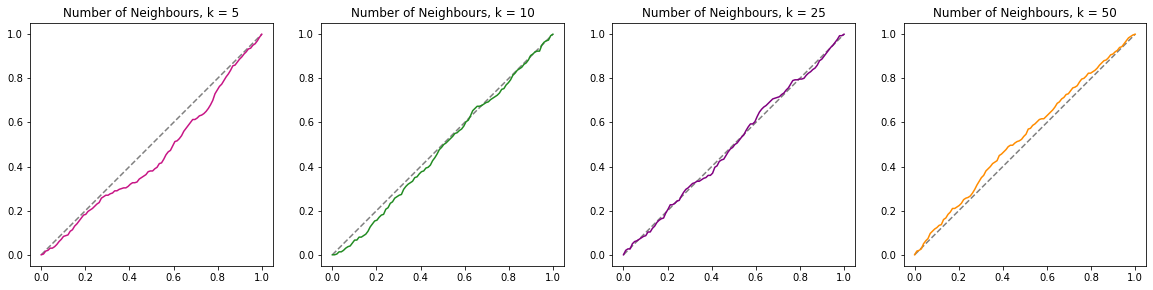

In [19]:
random.seed(100)

# Define the values of n_neighbors
neighbors_values = [5, 10, 25, 50]

custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']

# Create subplots
fig, axes = plt.subplots(1, len(neighbors_values), figsize=(20, 5))

# Loop through different values of n_neighbors
for i, n_neighbors in enumerate(neighbors_values):
    p_vals = []
    A_boots_list = []
    for m in A_true_draws:
        p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=2000, n_neighbors=n_neighbors)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    roc = []
    alphas = []
    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_vals < alpha)
        roc_point = num_below_alpha / len(p_vals)
        roc.append(roc_point)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
    power = roc[power_idx]

    axes[i].plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
    _ = axes[i].plot(alphas, roc, color=custom_colors[i])

    # Set title and aspect ratio
    axes[i].set_title("Number of Neighbours, k = {}".format(n_neighbors))
    axes[i].set_aspect('equal', adjustable='box')

# Save the plot
fig.savefig("MMSBM_n300_Q2000_M300_kchoices.png")

In [11]:
"""comments of degree heterogeneity"""

# when you have low degree, there is less information in the graph about you (the node). 
# THis means that other nodes oyu are similar to, at least by observation in the embedding space, 
# may not be from the same community as you. Thus this is more likely nearer the origin for a 
# degree heterogenous graph.
# The test cares that your bootstraps look like the observed graph, 
# the test doesn't care for whether the boundaries between communities are clear or fuzzy. 


'comments of degree heterogeneity'